In [1]:
import arviz as az
import matplotlib.pyplot as plt

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
import numpyro.distributions as dist
from numpyro.infer import SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
%matplotlib inline

# Bài tập của chương 2

### 2E1: Which of the expressions below correspond to the statement: the probability of rain on Monday?  
-> Pr(rain | Monday)

### 2E2. Which of the following statements corresponds to the expression: Pr(Monday | rain)?
-> The probability that it is Monday, given that it is raining.

### 2E3. Which of the expressions below correspond to the statement: the probability that it is Monday, given that it is raining?
-> Pr(Monday | rain)

### 2E4. The Bayesian statistician Bruno de Finetti (1906–1985) began his 1973 book on probability theory with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original, so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device for describing uncertainty from the perspective of an observer with limited knowledge; it has no objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What does it mean to say “the probability of water is 0.7”?
-> this mean the water proportion is not exactly 0.7, but the uncertainty around it. On the next toss you may get water with a prob of 0.7 or land with a prob of 0.3


### 2M1. Recall the globe tossing model from the chapter. Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for p.
(1) W, W, W  
(2) W, W, W, L  
(3) L, W, W, L, W, W, W  

In [2]:
def plot_2M(W=0, L=0, points=20, prior=None):
    fig, ax = plt.subplots(1, 3, figsize=(10,3), subplot_kw={"xlabel":"p", "yticks":[]})

    if prior is not None:
        p_grid = np.linspace(0,1, len(prior))
    else:
        p_grid = np.linspace(0,1, points)
        prior = np.repeat(1, points)

    likelihood = np.exp(dist.Binomial(total_count=W+L, probs=p_grid).log_prob(W))
    unstd_posterior = prior * likelihood
    posterior = unstd_posterior/ sum(unstd_posterior)

    ax[0].plot(p_grid, prior, ".-")
    ax[0].set_title("prior")
    ax[1].plot(p_grid, likelihood, ".-")
    ax[1].set_title("likelihood")
    ax[2].plot(p_grid, posterior, ".-")
    ax[2].set_title("posterior")
    fig.suptitle('DATA= '+ " W" * W + " L" * L, y=1.05, size=15, weight='demibold')

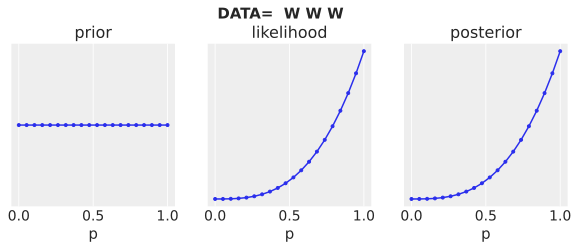

In [3]:
plot_2M(W=3)

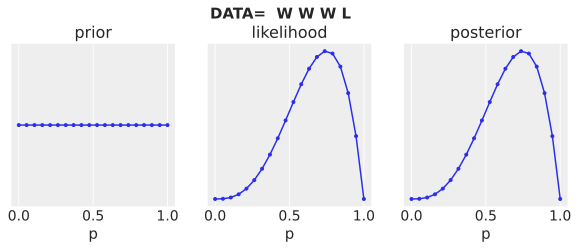

In [4]:
plot_2M(W=3, L=1)

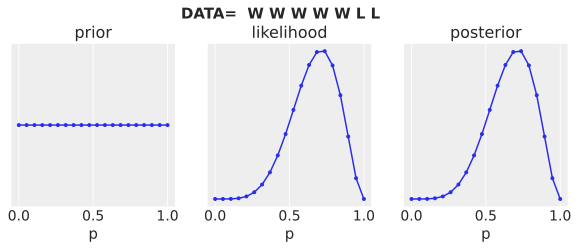

In [5]:
plot_2M(W=5, L=2)

### 2M2. Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.

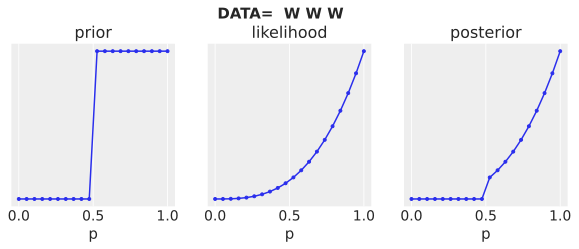

In [6]:
p_grid = np.linspace(0,1,20)
prior = np.where(p_grid>0.5, 1, 0)
plot_2M(W=3, prior=prior)

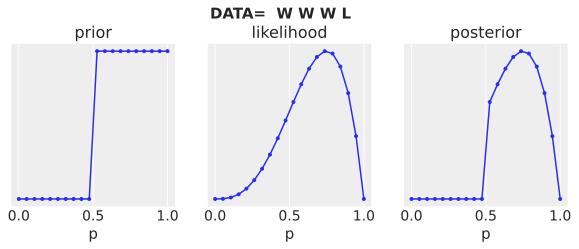

In [7]:
plot_2M(W=3, L=1, prior=prior)

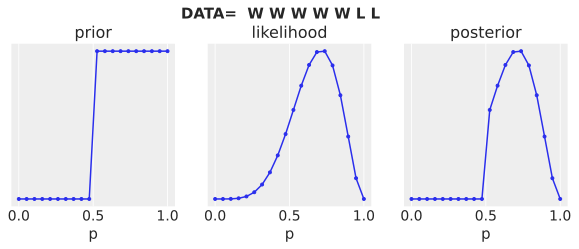

In [8]:
plot_2M(W=5, L=2, prior=prior)

How about the pointy prior?

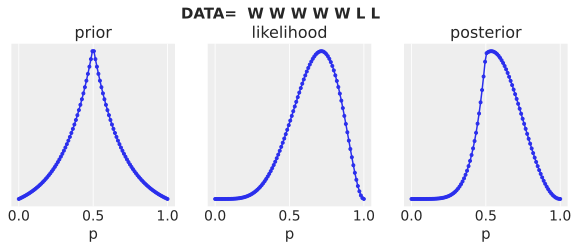

In [19]:
p_grid = np.linspace(0,1,100)
prior = np.exp(-5 * abs(p_grid - 0.5))
plot_2M(W=5, L=2, prior=prior)

### 2M3. Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know which—was tossed in the air and produced a “land” observation. Assume that each globe was equally likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on seeing “land” (Pr(Earth | land)), is 0.23.

In [9]:
def pure_bayes(prior, likelihood):
    prior = np.array(prior)
    likelihood = np.array(likelihood) 
    unstd_posterior = prior * likelihood
    return unstd_posterior/np.sum(unstd_posterior)

In [10]:
prior = [1,1] # [Earth, Mars]
likelihood = [0.3, 1] # data = one W so Pr(E|W)=0.3 and Pr(M|W)=1
pure_bayes(prior, likelihood)

DeviceArray([0.23076925, 0.7692308 ], dtype=float32)

### 2M4. Suppose you have a deck with only three cards. Each card has two sides, and each side is either black or white. One card has two black sides. The second card has one black and one white side. The third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up, but you don’t know the color of the side facing down. Show that the probability that the other side is also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This means counting up the ways that each card could produce the observed data (a black side facing up on the table).

In [11]:
prior = [1,1,1] # Pr of each card hidden in the bag are equal.
# with 1 black up
likelihood = [1,   # both black card
              0.5, # white and black
              0]   # both white
pure_bayes(prior, likelihood)

DeviceArray([0.6666667 , 0.33333334, 0.        ], dtype=float32)

### 2M5. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is drawn from the bag and a black side appears face up. Again calculate the probability that the other side is black.

In [12]:
# B/B, B/W, W/W, B/B
prior = [1,1,1,1]
likelihood = [1,0.5,0,1] 
posterior = pure_bayes(prior, likelihood)
print(posterior)
print("probability that the otherside is black =", posterior[0] + posterior[3])

[0.4 0.2 0.  0.4]
probability that the otherside is black = 0.8


### 2M6. Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that the probability the other side is black is now 0.5. Use the counting method, as before.

In [13]:
# B/B, B/W, W/W
prior = [1,2,3]
likelihood = [1,0.5,0]
posterior = pure_bayes(prior, likelihood)
print(posterior)
print("probability that the otherside is black =", posterior[0])

[0.5 0.5 0. ]
probability that the otherside is black = 0.5


### 2M7. Assume again the original card problem, with a single card showing a black side face up. Before looking at the other side, we draw another card from the bag and lay it face up on the table. The face that is shown on the new card is white. Show that the probability that the first card, the one showing a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat this like the sequence of globe tosses, counting all the ways to see each observation, for each possible first card.

In [14]:
# B/B, B/W, W/W
prior = [1,1,1]
likelihood = [1 * 0.75,
              0.5 * 0.5,
              0]
pure_bayes(prior, likelihood)

DeviceArray([0.75, 0.25, 0.  ], dtype=float32)

### 2H1. Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research.

### Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins?

In [15]:
# [A, B]
prior = [1,1]
likelihood = np.array([0.1, 0.2])
posterior = pure_bayes(prior, likelihood)
print(posterior)
nxt_twin = posterior * likelihood
print("prob that next birth will be twins =", np.sum(nxt_twin))

[0.3333333 0.6666666]
prob that next birth will be twins = 0.16666666


### 2H2. Recall all the facts from the problem above. Now compute the probability that the panda we have is from species A, assuming we have observed only the first birth and that it was twins.
-> 0.333

### 2H3. Continuing on from the previous problem, suppose the same panda mother has a second birth and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is species A.

In [16]:
prior = [1/3, 2/3] # from previous result
likelihood = [0.9, 0.2]
posterior_2H3 = pure_bayes(prior, likelihood)
posterior_2H3

DeviceArray([0.6923077 , 0.30769232], dtype=float32)

### 2H4. A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of the data, even if the data are of different types.

So suppose now that a veterinarian comes along who has a new genetic test that she claims can identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:

- The probability it correctly identifies a species A panda is 0.8.
- The probability it correctly identifies a species B panda is 0.65.

The vet administers the test to your panda and tells you that the test is positive for species A.  
First ignore your previous information from the births and compute the posterior probability that your panda is species A. Then redo your calculation, now using the birth data as well.

In [17]:
# [A,B]
priors = [np.array([1,1]),
          np.array([1/3, 2/3]),
          posterior_2H3
         ]
likelihood = [0.8, 0.35]
for prior in priors:
    print(f"with prior={np.round(prior,2)}:".ljust(25), "the prob of [A,B]=",pure_bayes(prior, likelihood))

with prior=[1 1]:         the prob of [A,B]= [0.6956522 0.3043478]
with prior=[0.33 0.67]:   the prob of [A,B]= [0.53333336 0.46666667]
with prior=[0.69 0.31]:   the prob of [A,B]= [0.83720934 0.1627907 ]
